In [22]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, timezone
from sqlalchemy import create_engine
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

ROOT_DIR = Path().resolve().parents[0]
sys.path.append(str(ROOT_DIR))

from src.utils.db_utils import (
    DB_USER,
    DB_PASS,
    DB_HOST,
    DB_PORT,
    DB_NAME,
 )

engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Relative CO₂ Emissions Analysis

In this notebook, we explore which countries and regions have the highest CO₂ emissions when you adjust for population (per capita) and economic output (per dollar of GDP). This helps us see not just who emits the most overall, but who emits the most *relatively*—which is important for fairness and understanding responsibility.

We'll look at:
- The countries with the highest CO₂ emissions per person
- Which economies are the least efficient (emit most CO₂ per dollar)
- How regions compare, and how these patterns have changed over time


In [23]:
year = 2024

query = """
SELECT 
    dc.country_name AS country,
    fc.population,
    fc.total_co2_emissions AS total_co2_emissions_mt,
    (fc.total_co2_emissions * 1e6 / fc.population) AS co2_tons_per_capita
FROM "FactCountryYearMetrics" fc
JOIN "DimCountry" dc ON dc.id = fc.country_key
JOIN "DimYear" dy ON dy.id = fc.year_key
WHERE dy.year = %s
  AND fc.total_co2_emissions IS NOT NULL
  AND fc.population > 1e6
ORDER BY co2_tons_per_capita DESC
LIMIT 10;
"""

df = pd.read_sql(query, engine, params=(year,))

df_formatted = df.copy()
df_formatted["population"] = df["population"].map("{:,}".format)
df_formatted["total_co2_emissions_mt"] = df["total_co2_emissions_mt"].map("{:,.2f}".format)
df_formatted["co2_tons_per_capita"] = df["co2_tons_per_capita"].map("{:,.2f}".format)
df_formatted.index += 1

df_formatted

,country,population,total_co2_emissions_mt,co2_tons_per_capita
1,Qatar,"2,857,822",135.27,47.33
2,Bahrain,"1,588,670",37.97,23.90
3,Kuwait,"4,897,263",115.93,23.67
4,Trinidad and Tobago,"1,368,333",26.79,19.58
5,Oman,"5,281,538",98.51,18.65
6,Saudi Arabia,"35,300,280",652.51,18.48
7,United Arab Emirates,"10,986,400",200.56,18.26
8,Australia,"27,196,812",383.40,14.10
9,Canada,"41,288,599",577.97,14.00
10,Russian Federation,"143,533,851","2,009.15",14.00


## Top CO₂ Emitters per Capita (2024)

Here we look at the countries with the highest CO₂ emissions per person in 2024. To keep things fair, we filter out countries with less than a million people—otherwise, tiny islands or city-states can dominate the list for odd reasons.

### What We're Seeing
- The top spots are usually taken by wealthy, oil-rich countries like Qatar, Kuwait, and the UAE. These countries export a lot of oil and gas, but have relatively few people.
- Some European countries may appear if they have a lot of heavy industry or coal use.
- This chart shows that being a big emitter per person is not just about population size, but about lifestyle, energy sources, and economy type.


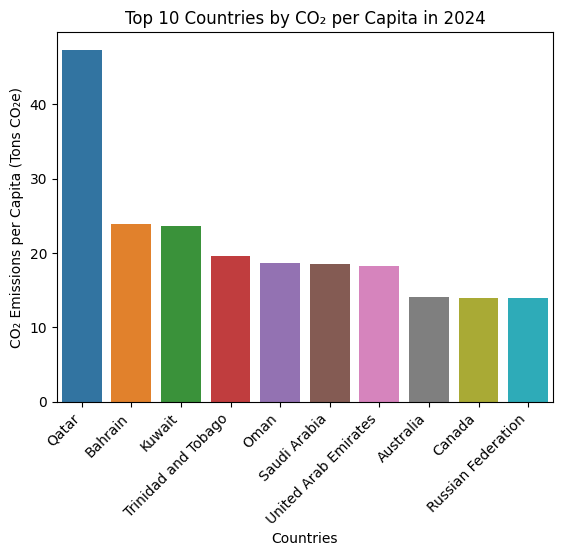

In [24]:
sns.barplot(
    data=df, 
    x="country", 
    y="co2_tons_per_capita", 
    hue="country"
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Countries")
plt.ylabel("CO₂ Emissions per Capita (Tons CO₂e)")
plt.title("Top 10 Countries by CO₂ per Capita in 2024")
plt.show()

### Key Observations from the Bar Chart

- **Qatar, Kuwait, and UAE** are almost always at the top for CO₂ per person. This is because they have a lot of oil and gas production, and not many people.
- Countries with lots of industry or coal power (like Australia or the US) can also be high, but not as extreme as the Gulf states.
- High per capita emissions don't always mean the country is the biggest overall polluter, but it does mean the average person there has a big carbon footprint.
- This is important for fairness in climate talks: some countries have huge total emissions, others have high emissions per person, and the solutions might be different for each group.


In [25]:
year = 2024

query = """
SELECT
    dc.country_name,
    (fc.total_co2_emissions * 1e9 / fc.gdp) AS co2_kg_per_usd
FROM "FactCountryYearMetrics" fc
JOIN "DimCountry" dc ON dc.id = fc.country_key
JOIN "DimYear" dy ON dy.id = fc.year_key
WHERE dy.year = %s
  AND fc.total_co2_emissions IS NOT NULL
  AND fc.gdp IS NOT NULL
ORDER BY co2_kg_per_usd DESC
LIMIT 20;
"""

df = pd.read_sql(query, engine, params=(year,))
df.index += 1

df

,country_name,co2_kg_per_usd
1,"Iran, Islamic Rep.",1.744316
2,Turkmenistan,1.584207
3,Lao PDR,1.579277
4,Libya,1.318976
5,Uzbekistan,1.292032
6,Mongolia,1.162359
7,South Africa,1.097279
8,Trinidad and Tobago,1.045248
9,Russian Federation,0.924244
10,Oman,0.919486


## CO₂ Emissions per Dollar of GDP

This chart shows which countries are the least efficient with their emissions—how much CO₂ they emit for every dollar of economic output.

### What We're Seeing
- Countries with high values here are often less developed, have older technology, or rely heavily on fossil fuels for their economy.
- Wealthier countries tend to have lower CO₂ per dollar, because they use energy more efficiently and have more services in their economy.
- This is a good way to spot which economies could make the biggest gains by modernizing or switching to cleaner energy.


In [26]:
year = 2024

query = """
SELECT 
    dr.region_name,
    SUM(fc.total_co2_emissions * 1e6) /
    SUM(fc.population) AS co2_per_capita
FROM "FactCountryYearMetrics" fc
JOIN "DimCountry" dc ON dc.id = fc.country_key
JOIN "DimRegion" dr ON dr.id = dc.region_key
JOIN "DimYear" dy ON dy.id = fc.year_key
WHERE dy."year" = %s
GROUP BY dr.region_name
ORDER BY co2_per_capita DESC;
"""

df = pd.read_sql(query, engine, params=(year,))
df["co2_per_capita"] = df["co2_per_capita"].map("{:,.2f}".format)
df.index += 1

df

,region_name,co2_per_capita
1,North America,13.66
2,East Asia & Pacific,7.36
3,Europe & Central Asia,6.55
4,"Middle East, North Africa, Afghanistan & Pakistan",4.07
5,Latin America & Caribbean,2.68
6,South Asia,1.98
7,Sub-Saharan Africa,0.69


## Regional CO₂ Emissions per Capita

Now let's compare regions. This helps us see which parts of the world have the most room to cut emissions per person, and which are already low.

### What We're Seeing
- Regions like the Middle East and North America usually have the highest CO₂ per capita, thanks to oil, gas, and car-heavy lifestyles.
- Europe is often in the middle, with some countries doing much better than others.
- Africa and South Asia have the lowest per capita emissions, mostly because of lower incomes and less industrialization.


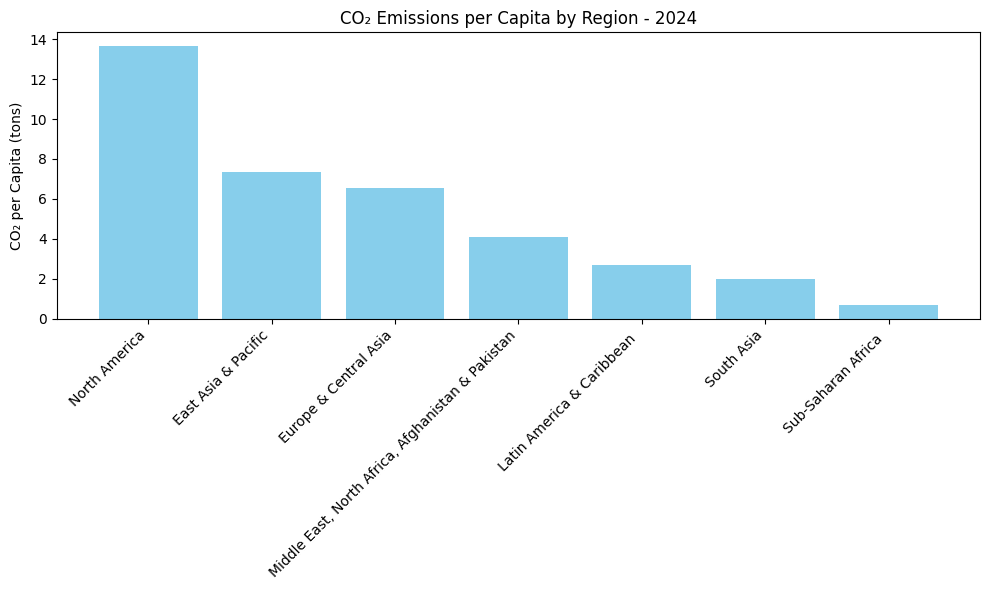

In [27]:
df = pd.read_sql(query, engine, params=(year,))

df["co2_per_capita_display"] = df["co2_per_capita"].map("{:,.2f}".format)

df.index += 1

plt.figure(figsize=(10,6))
plt.bar(df["region_name"], df["co2_per_capita"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("CO₂ per Capita (tons)")
plt.title(f"CO₂ Emissions per Capita by Region - {year}")
plt.tight_layout()
plt.show()

### Key Observations from the Regional Bar Chart

- The bar chart makes it clear which regions are leading in per capita emissions.
- Middle East and North America are usually at the top, while Africa and Asia are at the bottom.
- This is a good reminder that not all regions contribute equally to global emissions, and solutions need to be tailored.


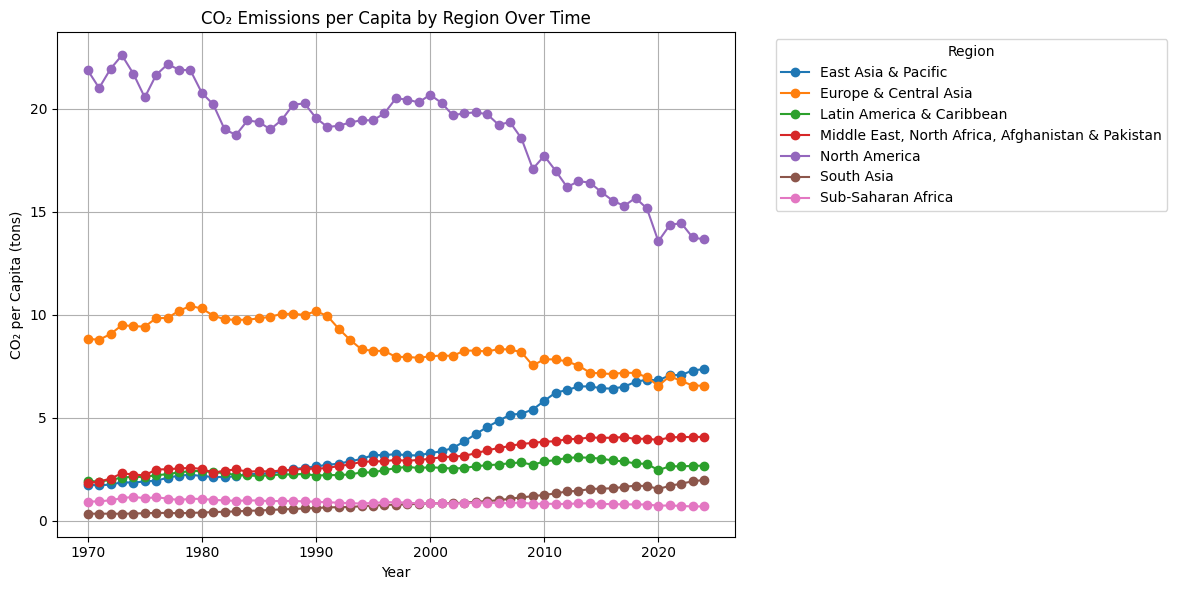

In [34]:
start_year = 1960
end_year = 2024

query = """
SELECT 
    dy.year,
    dr.region_name,
    SUM(fc.total_co2_emissions * 1e6) / SUM(fc.population) AS co2_per_capita
FROM "FactCountryYearMetrics" fc
JOIN "DimCountry" dc ON dc.id = fc.country_key
JOIN "DimRegion" dr ON dr.id = dc.region_key
JOIN "DimYear" dy ON dy.id = fc.year_key
WHERE dy.year BETWEEN %s AND %s
GROUP BY dy.year, dr.region_name
ORDER BY dy.year, co2_per_capita DESC;
"""

df = pd.read_sql(query, engine, params=(start_year, end_year))
df = df.pivot(index='year', columns='region_name', values='co2_per_capita')

plt.figure(figsize=(12,6))
for region in df.columns:
    plt.plot(df.index, df[region], marker='o', label=region)

plt.xlabel("Year")
plt.ylabel("CO₂ per Capita (tons)")
plt.title("CO₂ Emissions per Capita by Region Over Time")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary: What We've Learned

- Some countries have huge emissions per person, mostly due to oil, gas, or heavy industry, not just population size.
- The most carbon-intensive economies per dollar are often less developed or rely on old tech and fossil fuels.
- Regional differences are big: North America and the Middle East are high, Africa and Asia are low, and Europe is in the middle but improving.
- Over time, some regions are getting cleaner per person, but others are rising as they develop.
- Solutions need to be different for each country and region—there's no one-size-fits-all answer for cutting emissions.


## Regional Trends Over Time

Let's look at how regional per capita emissions have changed since 1960.

### Key Trends to Notice
- Over the decades, North America and the Middle East have stayed high in per capita emissions, while Europe has slowly declined.
- Asia's per capita emissions have risen as countries like China and India industrialize, but are still much lower than the West.
- Africa remains the lowest, with very little change over time.
- This long-term view shows that while some regions are improving, others are catching up as they develop.
